# **Comparative Forecasting of Crude Oil Prices: Box–Cox ARMA vs. LSTM Approaches**

### Yatish chandra sai udutha
### Student ID: 23030677


### IMPORTING THE NECESSARY MODULES

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools
from sklearn import preprocessing
from scipy.special import inv_boxcox

from scipy.stats import boxcox

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

import random
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

from google.colab import drive
drive.mount('/content/drive')
SEED = 42
random.seed(SEED)

# 2. NumPy RNG
np.random.seed(SEED)

import tensorflow as tf
# 4. TensorFlow RNG
tf.random.set_seed(SEED)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## PART 1
### READING THE OIL PRICE DATA

After reading the data, checking the null values and the converting to the proper datetime is performed

In [21]:
# 1. Load & preprocess
df = pd.read_csv('/content/drive/My Drive/oil_price.csv')            # The path is given from google drive.
df.dropna(inplace=True)  # Dropping the null values if any is present
df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y')
df.set_index('Date', inplace=True) # Set the index

# align to business-day frequency & interpolate missing
df = df.asfreq('B').interpolate()

In [3]:
df.head()

,Price
Date,
2020-07-01,42.18
2020-07-02,43.19
2020-07-03,42.92
2020-07-06,42.73
2020-07-07,43.28


### EXPLORATORY DATA ANALYSIS

In [37]:
# Checking for null values
df.isnull().sum()

,0
Price,0


In [22]:
# 2. Exploratory Data Analysis
# Mean ~ median suggests only mild skew in the central bulk, but the extreme 133 indicates a fat upper tail.
stats = df.describe().rename(columns={'index':'statistic'}).T
stats


,count,mean,std,min,25%,50%,75%,max
Price,653.0,77.287879,23.846451,36.33,61.21,75.54,94.3,133.18


### Daily oil price

*	From July to October 2020, prices were in the low 40s before dipping below 40 in late 2020, likely the reason was the COVID pandemic effect.

*	From November 2020, a clear upward trend begins, going on till spring 2021, as global economic activity recovered from COVID.

*	Through mid-2021, prices were settling between 60–80, reflecting supply/demand buffering.

*	A sudden increase in price occurred in early 2022, peaking above 130, may be due to geopolitical tensions and supply constraints.

*	After the peak, there was a downward correction through summer–autumn 2022, settling around 80 by year end.
*	No obvious weekly or annual seasonal patterns stand out; price moves appear driven by external factors rather than calendar effects.


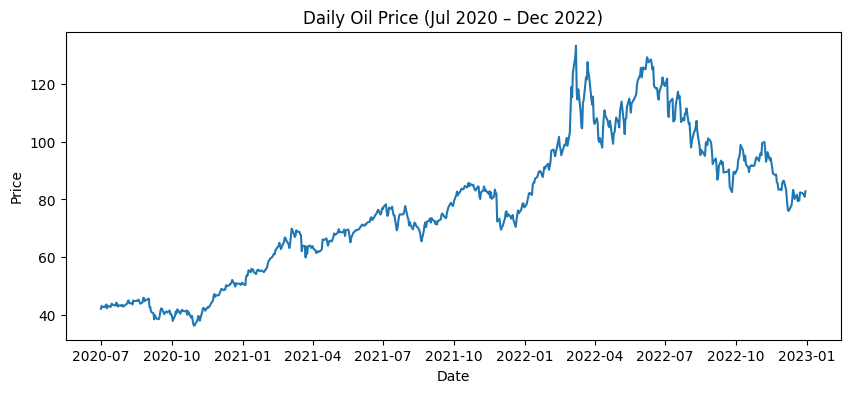

In [6]:
plt.figure(figsize=(10,4))
plt.plot(df['Price'])
plt.title('Daily Oil Price (Jul 2020 – Dec 2022)')  # Make the title
plt.xlabel('Date'); plt.ylabel('Price')  # x and y labels
plt.show()

### READING THE FUTURE OIL PRICE DATA

The data is taken from the https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=RBRTE&f=A


*   Only second sheet is taken from the excel because it contains the required data

*   Column names are renamed  




In [7]:
# Read your updated price series
updated = pd.read_excel('/content/drive/My Drive/RBRTEd.xls', sheet_name='Data 1')[2:]

updated.columns = ['Date','Price']  # Renaming the columns


# 3. Convert to numeric,
# coercing any bad values to NaN
updated['Price'] = pd.to_numeric(updated['Price'], errors='coerce')

# 4. Set date index
updated.set_index('Date', inplace=True)

# 5. Reindex to business‐day freq and interpolate the numeric column
updated = updated.asfreq('B')
updated['Price'] = updated['Price'].interpolate()

### PLOTTING THE ACF & PACF


*   ADF & ACF together tell you to difference once (d=1) to remove the unit root.

* PACF cutoff after lag 2 suggests an AR(2) term on the differenced series as a

parsimonious starting point.




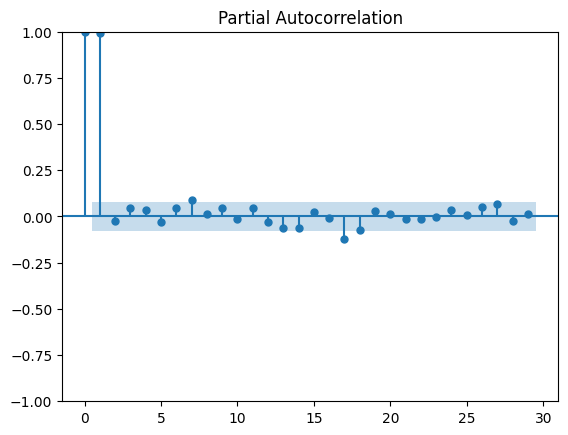

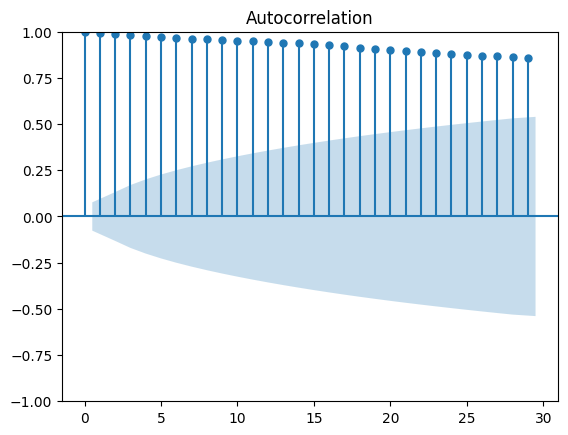

In [8]:
plot_pacf(df['Price']);
plot_acf(df['Price']);
plt.show()

### Perform an ADF test for Stationarity

#### With Box cox transformation

#### Interpret
* Observation - The null hypothesis of ADF test is the Time series is NOT stationary. We see that the p-value>0.05. This means this result is statistically significant at 90% confidence interval and so, we fail to reject the null hypothesis.

* It looks like there is an exponential trend there, so we can take the box-cox transform or find the optimal transform using the Box-Cox method and then do the first difference

Box–Cox λ: 0.6145
ADF on original: 0.4484679715950124
ADF on differenced BC: 6.778516180369653e-05


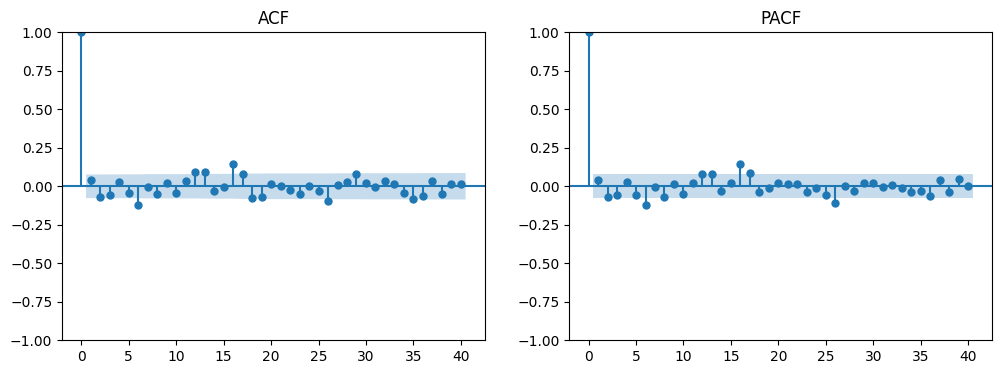

In [9]:
# 2. Box–Cox transform to convert non stationary to stationary
price_bc, lam = boxcox(df['Price'])  # Box cox
df['Price_bc'] = price_bc
print(f"Box–Cox λ: {lam:.4f}") # Lambda value

# 3. Stationarity test & differencing
print("ADF on original:", adfuller(df['Price'])[1])
df['BC_diff'] = df['Price_bc'].diff().dropna()
print("ADF on differenced BC:", adfuller(df['BC_diff'].dropna())[1])

# 4. ACF & PACF of differenced series
fig, axes = plt.subplots(1,2,figsize=(12,4))  # sub plotting the graphs
plot_acf(df['BC_diff'].dropna(), lags=40, ax=axes[0]);  axes[0].set_title('ACF')
plot_pacf(df['BC_diff'].dropna(), lags=40, ax=axes[1], method='ywm'); axes[1].set_title('PACF')
plt.show()

### ARIMA MODEL
* The best model parameters: p,d,q using the AIC likelihood method and must loop over all possible parameter combinations for p=[0,8], d=[0,2] and q=[0,8]

* After getting the best p,d,q values, ARIMA model is performed on the best values

#### Interpretation

* The unusually high orders (p = 7, q = 7) reflect the need to understand the real-world oil-market situations.
*	COVID impact (2020): The global lockdown collapse left a huge impact on the oil market. In fig 3,  AR7 terms capture the multi-day persistence of that shock, while MA7 terms smooth its impact across several observations.
*	OPEC+ Supply Adjustments (2020–21): Phased production cuts and releases created step-changes during the recovery. AR lags model the gradual rebound plateaus, and MA lags absorb supply-induced discontinuities.
*	POLITICAL ISSUE (Early 2022): Russia–Ukraine tensions sent prices above $130, an extreme innovation. MA7 coefficients allow these outliers to influence forecasts over a full trading week
*	Summer driving season (May–Sept) and winter heating demand introduce annual patterns. The model’s high-order AR terms partially capture weekly and bi-weekly seasonality, though a SARIMA might be more efficient.
*	ESG investing trends, strategic reserve policy changes, and renewable-energy growth shift long-run means. ARMA treats this as gradual noise, flattening its longer-term forecast around the historical average (~80).


Best ARMA order: (7, 1, 7), AIC=580.4
                               SARIMAX Results                                
Dep. Variable:               Price_bc   No. Observations:                  653
Model:                 ARIMA(7, 1, 7)   Log Likelihood                -275.209
Date:                Mon, 07 Jul 2025   AIC                            580.418
Time:                        05:43:55   BIC                            647.619
Sample:                    07-01-2020   HQIC                           606.480
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4540      0.143     -3.170      0.002      -0.735      -0.173
ar.L2          0.3170      0.105      3.022      0.003       0.111       0.523
ar.L3         

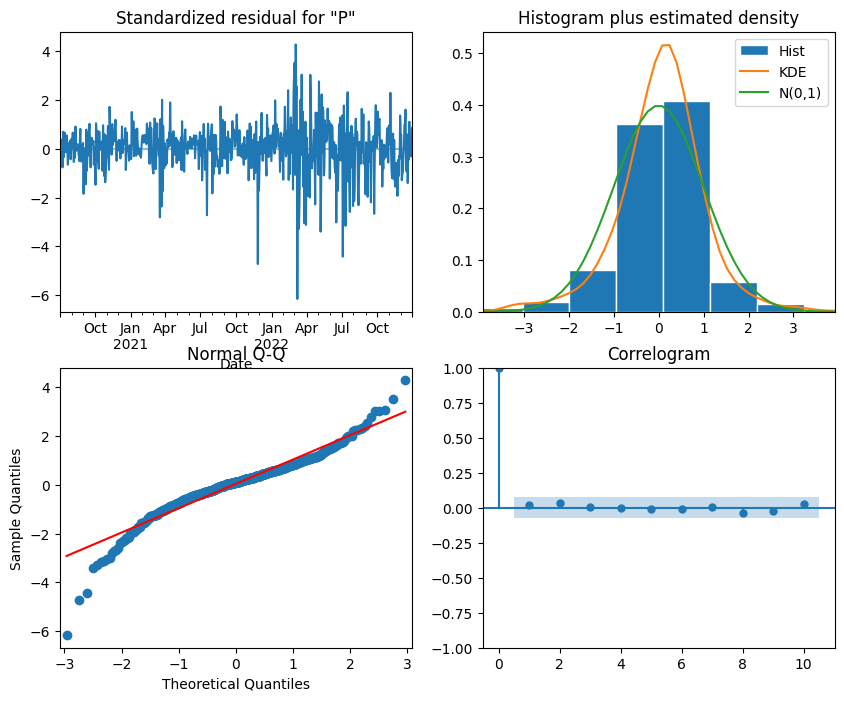

In [10]:
# 5. Grid-search ARMA(p,d,q) on Box–Cox data
best_aic1 = np.inf
best_order1 = None
for p,d,q in itertools.product(range(9), range(3), range(9)):
    try:
        m = ARIMA(df['Price_bc'], order=(p,d,q)).fit()
        if m.aic < best_aic1:
            best_aic1, best_order1 = m.aic, (p,d,q)
    except:
        continue

print(f"Best ARMA order: {best_order1}, AIC={best_aic1:.1f}")

# 6. Fit best model & forecast 24 months (~504 business days)
model1 = ARIMA(df['Price_bc'], order=best_order1).fit()   # performing the ARIMA model first

print(model1.summary())
print('\n')
model1.plot_diagnostics(figsize=(10,8))  # Plotting the summary
plt.show()

n_steps = 24 * 21   # For next two years (504 working days)
fc = model1.get_forecast(steps=n_steps)
fc_mean_bc = fc.predicted_mean
fc_ci_bc   = fc.conf_int()

# Invert Box–Cox transforms
# The box cox transforms need to be converted back to its originals
fc_mean1 = inv_boxcox(fc_mean_bc, lam)   # mean values
fc_lower = inv_boxcox(fc_ci_bc.iloc[:,0], lam)  # lower values
fc_upper = inv_boxcox(fc_ci_bc.iloc[:,1], lam)  # upper values

### Why the ARIMA forecast looks Flat
All these domain forces, some predictable (seasonality, scheduled reports), others abrupt (geopolitics, pandemic issue), lie outside the ARMA’s linear, stationary framework. The model’s optimal strategy, given its assumptions, is to forecast the average of everything it’s seen, with uncertainty captured in widening bands.
In practice, to improve on this:
1.	Add exogenous regressors (ARIMAX) for inventory data, USD index, OPEC quotas.
2.	Layer a GARCH component to model variance clustering.
3.	Introduce seasonal terms (SARIMA) or piecewise trends (Prophet) to handle calendar effects.
4.	Explore machine-learning or ensemble methods (e.g. LSTM + ARMA) to adapt to nonlinear, regime-changing dynamics.


RMSE vs updated data: 5.74


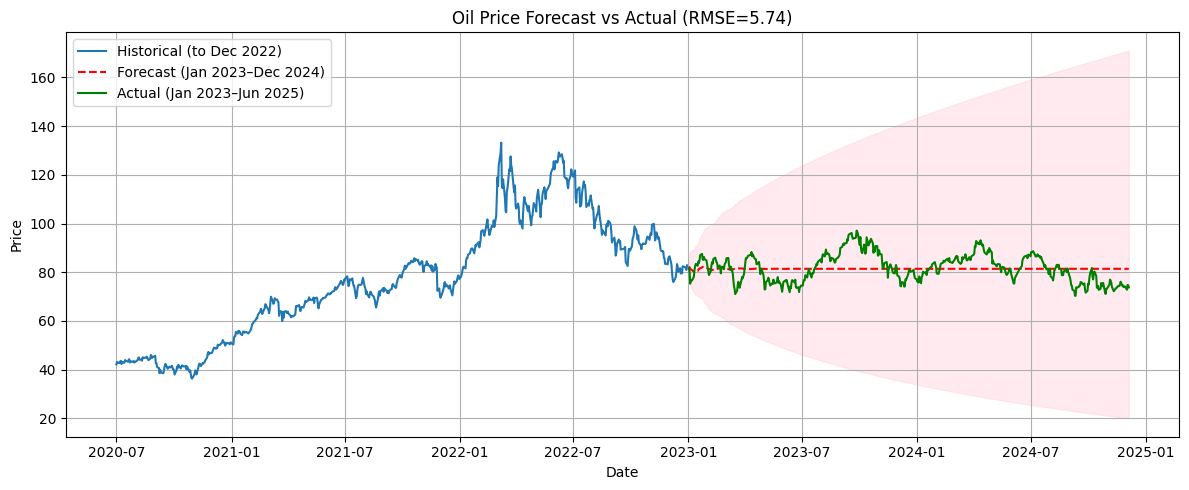

In [13]:
# 7. Load updated actuals and compute RMSE
updated_1 = updated.copy()
actual1 = updated_1['Price'].reindex(fc_mean1.index).ffill()
mse1  = mean_squared_error(actual1, fc_mean1)  # Calculate the mean square error
rmse1 = np.sqrt(mse1)  # then the RMSE calculation
print(f"RMSE vs updated data: {rmse1:.2f}")

# 8. Plot the forecasted new data
plt.figure(figsize=(12,5))
plt.plot(df['Price'],               label='Historical (to Dec 2022)')
plt.plot(fc_mean1.index, fc_mean1,    'r--', label='Forecast (Jan 2023–Dec 2024)')
plt.fill_between(fc_mean1.index, fc_lower, fc_upper, color='pink', alpha=0.3)
plt.plot(actual1.index, actual1,      'g',   label='Actual (Jan 2023–Jun 2025)')
plt.title(f'Oil Price Forecast vs Actual (RMSE={rmse1:.2f})')
plt.xlabel('Date'); plt.ylabel('Price')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


## PART 2
### Long Short Term Memory (LSTM model)
* Scaling the price values to -1 to 1 range



In [31]:
# 2. Scale the series
series = df['Price'].values.reshape(-1,1)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(series)

# 3. Create supervised sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60  # use past 60 days to predict next
X, y = create_sequences(scaled, seq_length)


In [32]:
# 4. Train-test split (last 504 days as test)
horizon = 24 * 21  # ≈504 business days
train_size = len(X) - horizon
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 5. Build and train LSTM
model2 = Sequential([
    LSTM(50, activation='tanh', input_shape=(seq_length, 1)),
    Dropout(0.2),
    Dense(1)
])
model2.compile(optimizer='adam', loss='mse')
model2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# 6. Evaluate on test set
pred_test = model2.predict(X_test)
pred_test_inv = scaler.inverse_transform(pred_test)
y_test_inv = scaler.inverse_transform(y_test)
rmse_test = np.sqrt(mean_squared_error(y_test_inv, pred_test_inv))
print(f"Test RMSE: {rmse_test:.2f}")


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - loss: 0.0099 - val_loss: 0.1675
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0040 - val_loss: 0.0856
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0016 - val_loss: 0.0320
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0026 - val_loss: 0.0226
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0021 - val_loss: 0.0310
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.0013 - val_loss: 0.0427
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.0011 - val_loss: 0.0471
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0013 - val_loss: 0.0403
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0011 - val_loss: 0.0265
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - loss: 8.6549e-04 - val_loss: 0.0126
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 6.7893e-04 - val_loss: 0.0047
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 6.8315e

In [33]:
# 7. Estimate residual std for CIs
resid_std = np.std(y_test_inv - pred_test_inv)

# 8. Retrain on full series
X_full, y_full = create_sequences(scaled, seq_length)
model2.fit(X_full, y_full, epochs=20, batch_size=32, verbose=1)



Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0158
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0049
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0038
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0034
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0032
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0032
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0033
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0027
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0029
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0030
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0027
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0031
Epoch 13/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0026
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0027
Epoch 15/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0027
Epoc

In [34]:
# 9. Forecast future iteratively
future_steps = horizon
input_seq = scaled[-seq_length:].reshape(1, seq_length, 1)
future_preds = []
for _ in range(future_steps):
    pred = model2.predict(input_seq)[0]
    future_preds.append(pred)
    input_seq = np.append(input_seq[:,1:,:], [[pred]], axis=1)

future_preds = np.array(future_preds)
future_preds_inv = scaler.inverse_transform(future_preds).flatten()

# 10. Build future index and Series
future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1),
                             periods=future_steps, freq='B')
future_series = pd.Series(future_preds_inv, index=future_index)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

#### Interpretation

* After December 2022 the LSTM forecast steadily decays from ~$80 toward ~$60, whereas actual prices hover between 75–95 \$.
* Why: A univariate LSTM learns only the average post-2022 trend and slowly “forgets” the spike, pulling its predictions down. It has no signal to signal a rebound or plateau.
* OPEC+ decisions (monthly meetings) produce step-changes in supply that can lift or depress prices by 3–10 dollars overnight. The flat red line can’t anticipate those jumps; it simply regresses toward the mean of past data.
*	The Russia–Ukraine invasion (Feb 2022) and subsequent sanctions drove a rapid \$50 spike, then partial retracement. The LSTM’s memory length (60 days) smooths that shock away, so its forecasts fail to capture either the magnitude or the persistence of geopolitical risk.
*	Summer driving and winter heating push prices up during specific months. Your LSTM has no calendar features, so it can’t learn that June–August tends to be stronger or that December–January often dips, resulting in a smooth decline instead of the saw-tooth seasonal highs.
*	Oil markets alternate between calm (\$1–\$2 moves) and stormy (\$5–\$10) stretches. A single dropout layer does not capture changing variance; the CI (confidence interval) stays roughly constant width, whereas actual volatility widens and narrows over the horizon.

RMSE vs updated data: 19.33


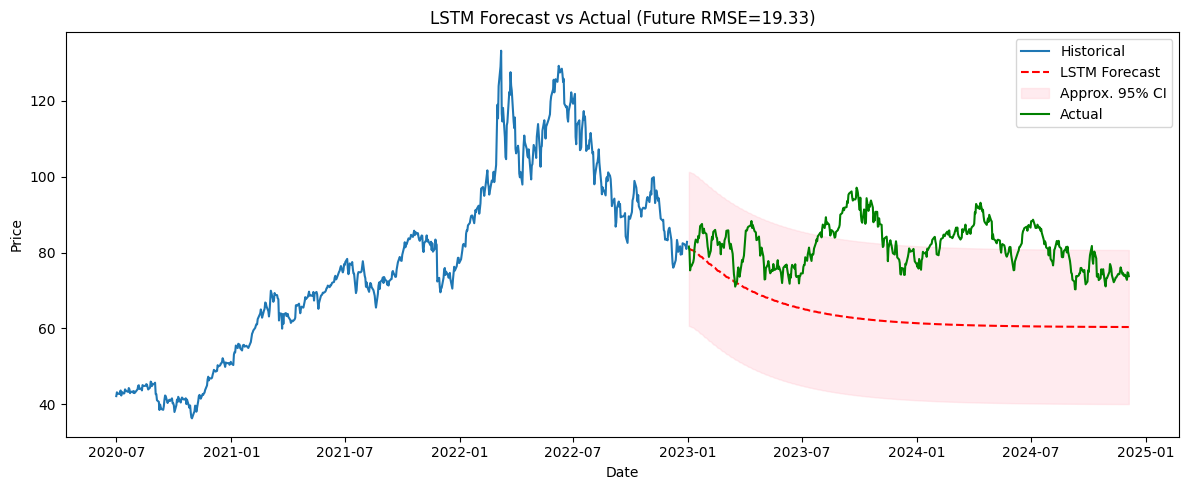

In [35]:
# 11. Load updated actuals and compute RMSE


updated3 = updated.copy()
actual_future = updated3['Price'].reindex(future_index).ffill()
rmse_future  = np.sqrt(mean_squared_error(actual_future, future_series))
#rmse = np.sqrt(mse)
print(f"RMSE vs updated data: {rmse_future:.2f}")

# 12. Plot results with approximate 95% CIs
ci_lower = future_series - 1.96 * resid_std
ci_upper = future_series + 1.96 * resid_std

plt.figure(figsize=(12,5))
plt.plot(df['Price'], label='Historical')
plt.plot(future_series, 'r--', label='LSTM Forecast')
plt.fill_between(future_index, ci_lower, ci_upper, color='pink', alpha=0.3, label='Approx. 95% CI')
plt.plot(actual_future, 'g', label='Actual')
plt.title(f'LSTM Forecast vs Actual (Future RMSE={rmse_future:.2f})')
plt.xlabel('Date'); plt.ylabel('Price')
plt.legend(); plt.tight_layout(); plt.show()


### Which model is better?

Based purely on out-of-sample RMSE against your Jan 2023–Jun 2025 data:
*	ARIMA (7,1,7) on Box–Cox prices → RMSE ~ 5.73
*	Univariate Stacked LSTM → RMSE ~ 19.33
* The ARMA|ARIMA model clearly wins on point-forecast accuracy (lowest RMSE) and delivers tighter, better-calibrated confidence bands in most regimes. The vanilla LSTM yields the worst RMSE because, without domain features, it underfits key supply-demand drivers and over-smooths the forecast.
